# Import packages

In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.sparse.linalg import lsqr
import scipy as sp
import rioxarray
from gravbox import * 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', message="pandas.Int64Index")
warnings.filterwarnings('ignore', message="pandas.Float64Index")
# Plotting maps using GMT
import pygmt
import geopandas as gpd

# The Fatiando stack
import harmonica as hm
from grav_column_der import grav_column_der

import os 

os.getcwd()

'/Users/home/tankerma/RIS_gravity_inversion'

# To Do
* add plotting function
    * choose between fast mpl and slow pygmt
* interpolate regional gravity to full inv_reg
* add actual grav observation elevations
* use discretize package to increase grid spacing outside of fig_reg
* implement scipy optimize to compare with grav_column_der
* add control points to inversion constraints
* fix density inversion
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

# Set regions / plotting params

In [17]:
# RIS tight extent
e_fig = -560000
w_fig = 400000
n_fig = -1400000
s_fig = -440000

# RIS zoomed in extent
# zoom = 400e3
# e_fig = -560000+zoom
# w_fig = 400000-zoom
# n_fig = -1400000+zoom
# s_fig = -440000-zoom

# RIS zoomed and south shifted extent
zoom = 300e3
shift = 200e3
e_fig = -560000+zoom
w_fig = 400000-zoom
n_fig = -1400000+zoom-shift
s_fig = -440000-zoom-shift

fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"
fig_reg_ll = "-180/180/-90/-71"
buffer = 200e3

e_inv = int(e_fig-buffer)
w_inv = int(w_fig+buffer)
n_inv = int(n_fig-buffer)
s_inv = int(s_fig+buffer)
inv_reg = [e_inv, w_inv, n_inv, s_inv]
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"
inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"

# region for clipping grids in RIS_bathymetry_data.ipynb
# buffer = 200e3
# e_regional = int(e_inv-buffer)
# w_regional = int(w_inv+buffer)
# n_regional = int(n_inv-buffer)
# s_regional = int(s_inv+buffer)
# regional_reg = [e_regional, w_regional, n_regional, s_regional]
# regional_reg

def plot_coast(projection = fig_proj, region = fig_reg):
        fig.plot(
                projection = projection, 
                region = region,
                data = gpd.read_file('plotting/GroundingLine_Antarctica_v02.shp'), 
                pen = '1.2p,black', 
                verbose='q',
                )
        fig.plot(data = gpd.read_file('plotting/Coastline_Antarctica_v02.shp'), 
                pen = '1.2p,black',
                verbose='q',
                )

def plot_constraints(projection = fig_proj, region = fig_reg, df = None):
        if df is None:
                df = constraints_df
        fig.plot(
                x = df.x, 
                y = df.y, 
                style = 'c1.2p',
                color = 'black',
                projection = projection,
                region = region, 
                )

def plot_inv_box(projection = fig_proj, region = fig_reg):
        fig.plot(
                x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
                y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
                pen = '2p,black', 
                projection = projection,
                region = region,
                )

def plot_grd(
        grid, 
        cmap : str, 
        cbar_label : str, 
        plot_region=inv_reg, 
        cmap_region=fig_reg, 
        coast=True,
        constraints=False,
        # grd2cpt=False, 
        subplots=False,
        ):
    global fig, plot_width, plot_height, projection 
    
    if plot_region == inv_reg:
        projection = inv_proj
        plot_width = inv_width
        plot_height = inv_height
    elif plot_region == fig_reg:
        projection = fig_proj
        plot_width = fig_width
        plot_height = fig_height
    # initialize figure or shift for new subplot
    if subplots==False:
        fig = pygmt.Figure()   
    else:
        fig.shift_origin(xshift=(plot_width +2)/10)
    
    # set cmap
    # if grd2cpt==True:
    #     pygmt.grd2cpt(cmap=cmap, grid=grid, region=cmap_region, background=True)
    # else:
    #     pygmt.makecpt(cmap = cmap)

    fig.grdimage(
        grid=grid,
        cmap=cmap,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])

    fig.colorbar(
        cmap=cmap, 
        position='jBC+jTC+h', 
        frame=f'x+l"{cbar_label}"')

    if coast==True:
        plot_coast(projection = projection, region = plot_region)

    if constraints==True:
        plot_constraints(projection = projection, region = plot_region)

    if plot_region==inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

SyntaxError: name 'plot_region' is parameter and global (1784701350.py, line 99)

# Import data

In [3]:

layers_list =[
             'ice',
             'water',
             'bathymetry',
             'basement',
]
spacing_list = [
                20e3,
                20e3,
                20e3,
                20e3,
]
rho_list = [
            920,
            1030,
            2600,
            2800,
]

grav_spacing = 20e3

# fig_reg_str=f'{e_fig}/{w_fig}/{n_fig}/{s_fig}'
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# resample gravity to just within the figure region (without buffer)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{grav_spacing}  gravity_data/ant4d_gravity.nc -Ginversion_layers/gravity_inv.nc
# resample layer grids to inversion region (with buffer)
# surface (ice)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[0]}  inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# icebase (water)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[1]}  inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# bathymetry (sediment)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  inversion_layers/bedmachine/BedMachine_bed_5k.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# basement (crust)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/ANTASed_mag_basement_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/RE_basement_BedMachinebed_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 


# Fabio's test grids
# !gmt grdsample -R{inv_reg_str} -rg -I{grav_spacing}  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[0]}  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[1]}  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[2]}  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[3]}  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 


# add bathymetry control points
!gmt grdsample -R{inv_reg_str} -rg -Vn -I1000 inversion_layers/constraints_grid.nc -Ginversion_layers/constraints_grid.nc 
fname = 'inversion_layers/constraints_grid.nc'
constraints_grid = xr.load_dataset(fname)

fname = 'bathymetry_data/bedmachine_RIGGS.csv'
constraints_df =  pd.read_csv(fname, index_col=False)

!gmt grdmask plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{inv_reg_str} -NNaN/NaN/1
constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')

fname_list=[
            'inversion_layers/BedMachine_surface_filled_inv.nc',
            'inversion_layers/BedMachine_icebase_filled_inv.nc',
            'inversion_layers/BedMachine_bed_inv.nc',
            'inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
            ]

layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}

for k, v in layers.items():
    v['grid']=xr.load_dataset(v['fname'])
    v['df']=xr.load_dataset(v['fname']).to_dataframe().reset_index()
    v['df']['rho']=v['rho']
    v['df'].dropna(how='any', inplace=True)
    # v['grid']=pygmt.xyz2grd(v['df'][['x','y','z']], region=inv_reg, spacing=v['spacing'])
    # v['grid']=v['grid'].to_dataset(name='z')
    # v['grid']
    v['len']=len(v['df'].x)  

fname='inversion_layers/gravity_inv.nc'
grid_grav = xr.load_dataset(fname)           
df_grav = xr.load_dataset(fname).to_dataframe().reset_index() 
df_grav.rename(columns={'z':'Gobs'}, inplace=True)
df_grav.dropna(how='any', inplace=True)
df_grav['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750
# grid_grav=pygmt.xyz2grd(df_grav[['x','y','Gobs']], region=inv_reg, spacing=grav_spacing)
# grid_grav=grid_grav.to_dataset(name='z')

for k, v in layers.items():
    print(f"points in {k} file: {v['len']}") 

print(f'points in gravity file: {len(df_grav)}')    
print(f'number of strict bathymetry control points:{len(constraints_df)}')    

points in ice file: 1521
points in water file: 1521
points in bathymetry file: 1521
points in basement file: 1521
points in gravity file: 1521
number of strict bathymetry control points:10475932


# Show layers

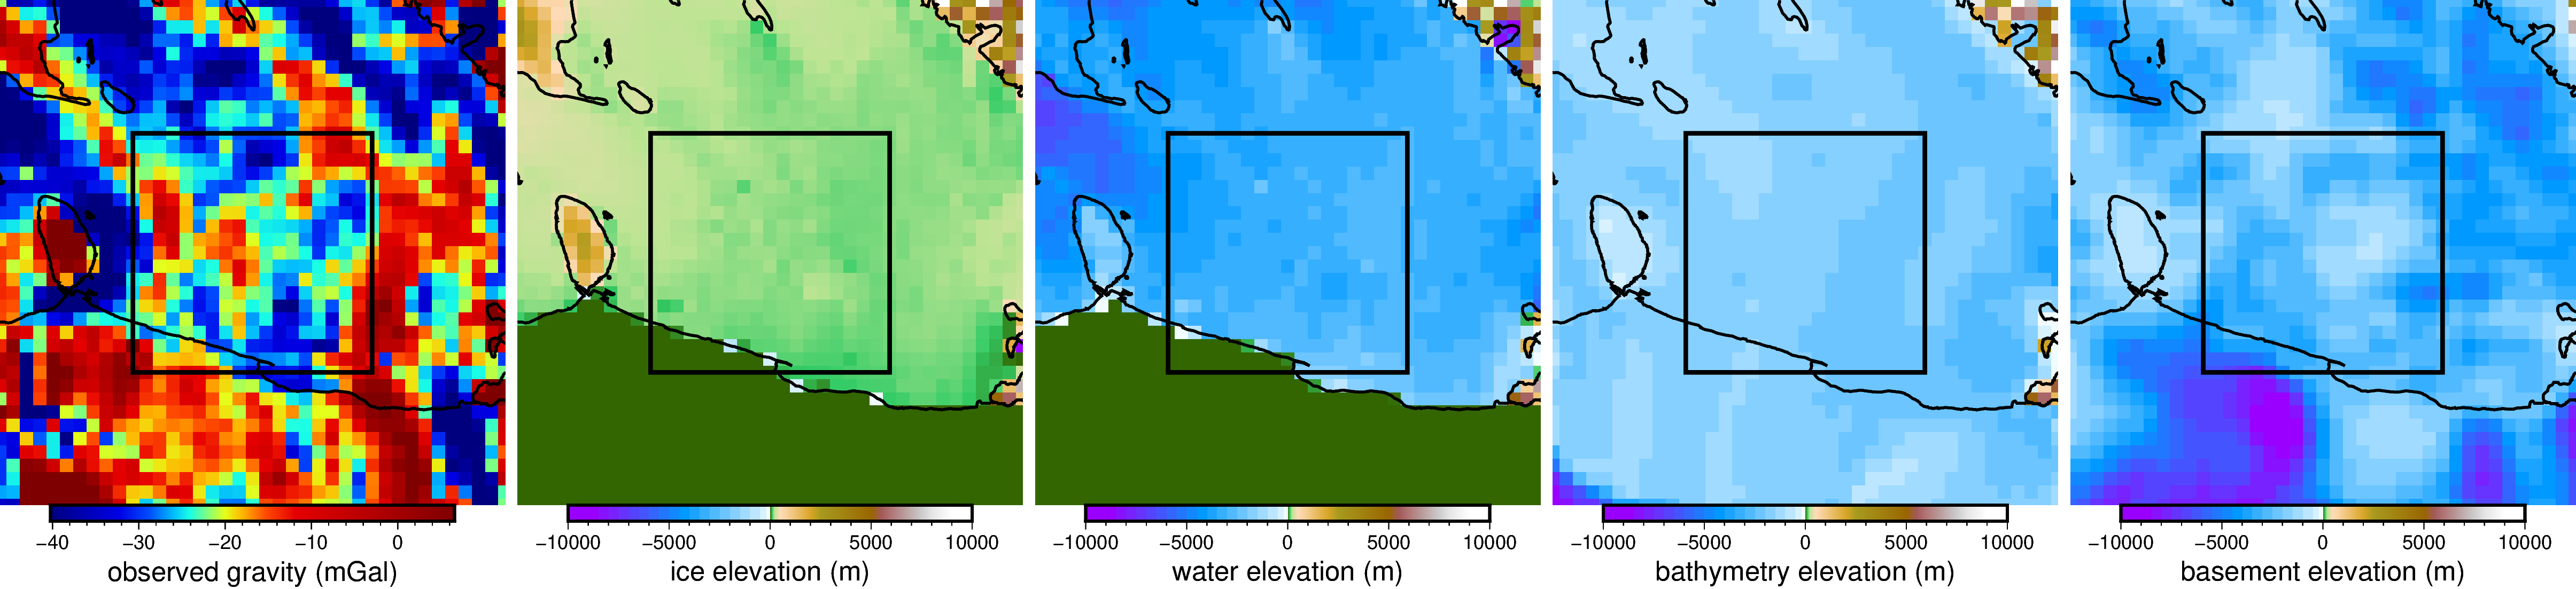

In [4]:
pygmt.grd2cpt(
    cmap="jet", 
    grid=grid_grav.z, 
    region=fig_reg, 
    continuous=True, 
    background=True, 
    output = 'plotting/grav.cpt')

plot_grd(
    grid = grid_grav.z, 
    cmap = "plotting/grav.cpt",
    cbar_label = "observed gravity (mGal)",
    )

for i, (k, v) in enumerate(layers.items()):
    plot_grd(
        grid=layers[k]['grid'].z, 
        cmap = "globe",
        cbar_label = f"{k} elevation (m)",
        subplots=True,
        )

fig.show()

# Calc forward gravity

In [5]:
def forward_grav_layers(layers):
    # Calculate inital forward gravity model of input layer
    # add density variable to datasets
    for k ,v in layers.items():
        v['grid']['density']=v['grid'].z.copy()
        v['grid'].density.values[:] = v['rho']

    # list of layers, bottom up
    reversed_layers_list = np.flip(layers_list[:])

    for i, j in enumerate(reversed_layers_list):
        if i == 0:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                # reference=-5e3,
                reference = np.nanmin(layers[j]['grid'].z.values)*2, # bottom of prisms is twice the deepest depth
                properties={'density':layers[j]['grid'].density})
            print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')

        else:
            if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
                print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
                print(f"resampling {reversed_layers_list[i-1]} to match {j}")
                tmp = layers[j]['grid'].z.to_dataframe().reset_index()
                tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                            grid = layers[reversed_layers_list[i-1]]['grid'].z, 
                                            newcolname = 'z_regrid')
                tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
                tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = inv_reg, spacing = layers[j]['spacing'])

                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'].z, 
                    reference=tmp_grd,
                    properties={'density':layers[j]['grid'].density})
                print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')
            else:
                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'].z, 
                    reference=layers[reversed_layers_list[i-1]]['grid'].z,
                    properties={'density':layers[j]['grid'].density})
                print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')

    print('starting forward gravity calculations and gridding')
    for k, v in layers.items():
        df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
        print(f'finished {k} layer')
        layers[k]['forward_grav'] = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                            region=inv_reg, spacing=grav_spacing, projection=inv_proj) 

    # add gravity effects of all input layers
    for i, j in enumerate(layers_list):
        if i == 0:
            df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
        else:
            df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

    # print(df_grav.describe())
    # return df_grav, layers 

forward_grav_layers(layers=layers)

mean elevation of basement top: -2644.336181640625 and bottom: -15821.453125
mean elevation of bathymetry top: -567.5796508789062 and bottom: -2644.468505859375
mean elevation of water top: -210.47372436523438 and bottom: -570.7496948242188
mean elevation of ice top: 58.0676155090332 and bottom: -213.59361267089844
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer
finished basement layer


# Calc anomalies

In [6]:
# calculate anomalies in gravity dataframe
df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average initial misfit within figure region is {int(shift)} mGal')

df_grav['Gobs_shift'] = df_grav.Gobs - shift
print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total
misfit_shift = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average misfit between Gobs_shift and forward gravity within figure region is {misfit_shift} mGal')

# make grids of anomalies
Gobs_shift_grid=pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

Gfor_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

Gmisfit_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

# sample Gobs_shift grid at contraint points
tmp_regrid = pygmt.grdtrack(points = constraints_df[['x','y']], 
                            grid = Gobs_shift_grid,
                            newcolname = 'Gobs_sampled')
constraints_df['Gobs_shift']=constraints_df.merge(tmp_regrid, how = 'left', on = ['x','y']).Gobs_sampled
# grid and interpolate gravity at constraints
Gfor_constraints_grid = pygmt.surface(data=constraints_df[['x','y','Gobs_shift']], region=inv_reg, spacing=grav_spacing,)
# Gfor_constraints_grid = pygmt.xyz2grd(constraints_df[['x','y','Gobs_shift']], region = inv_reg, spacing = grav_spacing)
# Gfor_constraints_grid = Gfor_constraints_grid.rio.write_crs("epsg:3031")
# Gfor_constraints_grid = Gfor_constraints_grid.rio.interpolate_na(method='cubic')
# add to dataframe
df_grav['Gobs_constraints'] = Gfor_constraints_grid.transpose().to_dataframe().reset_index().z
# Gfor_constraints_grid = pygmt.xyz2grd(df_grav[['x','y','Gobs_constraints']], region=inv_reg, spacing=grav_spacing)
df_grav['Gmisfit_constraints'] = df_grav.Gobs_constraints - df_grav.forward_grav_total

Gmisfit_constraints_grid=pygmt.xyz2grd(data = df_grav[['x','y','Gmisfit_constraints']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

average initial misfit within figure region is -1780 mGal
average Gobs_shifted: 1758 mGal
average misfit between Gobs_shift and forward gravity within figure region is 3.1241051680413056e-05 mGal


grdtrack [WARNING]: Some input points were outside the grid domain(s).
surface [WARNING]: 789778 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


# Plot forward gravity

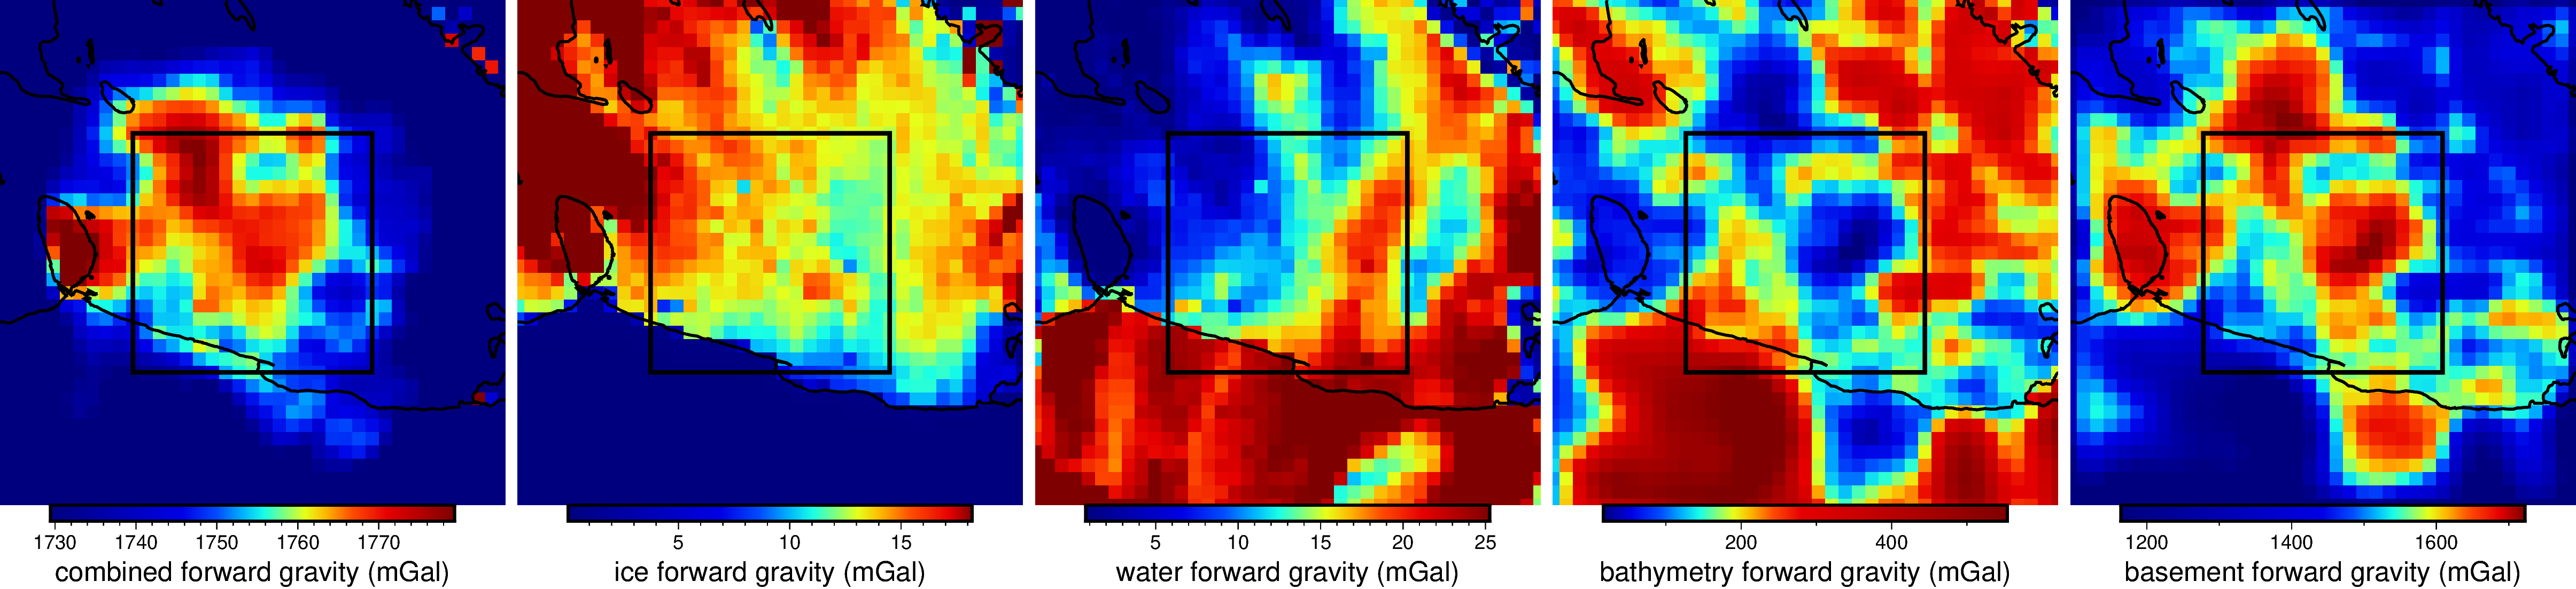

In [7]:
pygmt.grd2cpt(
    cmap="jet", 
    grid=Gfor_grid, 
    region=fig_reg, 
    background=True, 
    continuous=True,
    output = 'plotting/grav.cpt')

plot_grd(
    grid=Gfor_grid,
    cmap='plotting/grav.cpt',
    cbar_label = f"combined forward gravity (mGal)",)

for i, (k, v) in enumerate(layers.items()):
    pygmt.grd2cpt(
        cmap="jet", 
        grid=v['forward_grav'], 
        region=fig_reg, 
        background=True, 
        continuous=True,
        output = 'plotting/grav.cpt')
    cmap='plotting/grav.cpt'
    plot_grd(
        grid=v['forward_grav'], 
        cmap = cmap,
        cbar_label = f"{k} forward gravity (mGal)",
        subplots=True,)
    
fig.show()

# Plot gravity

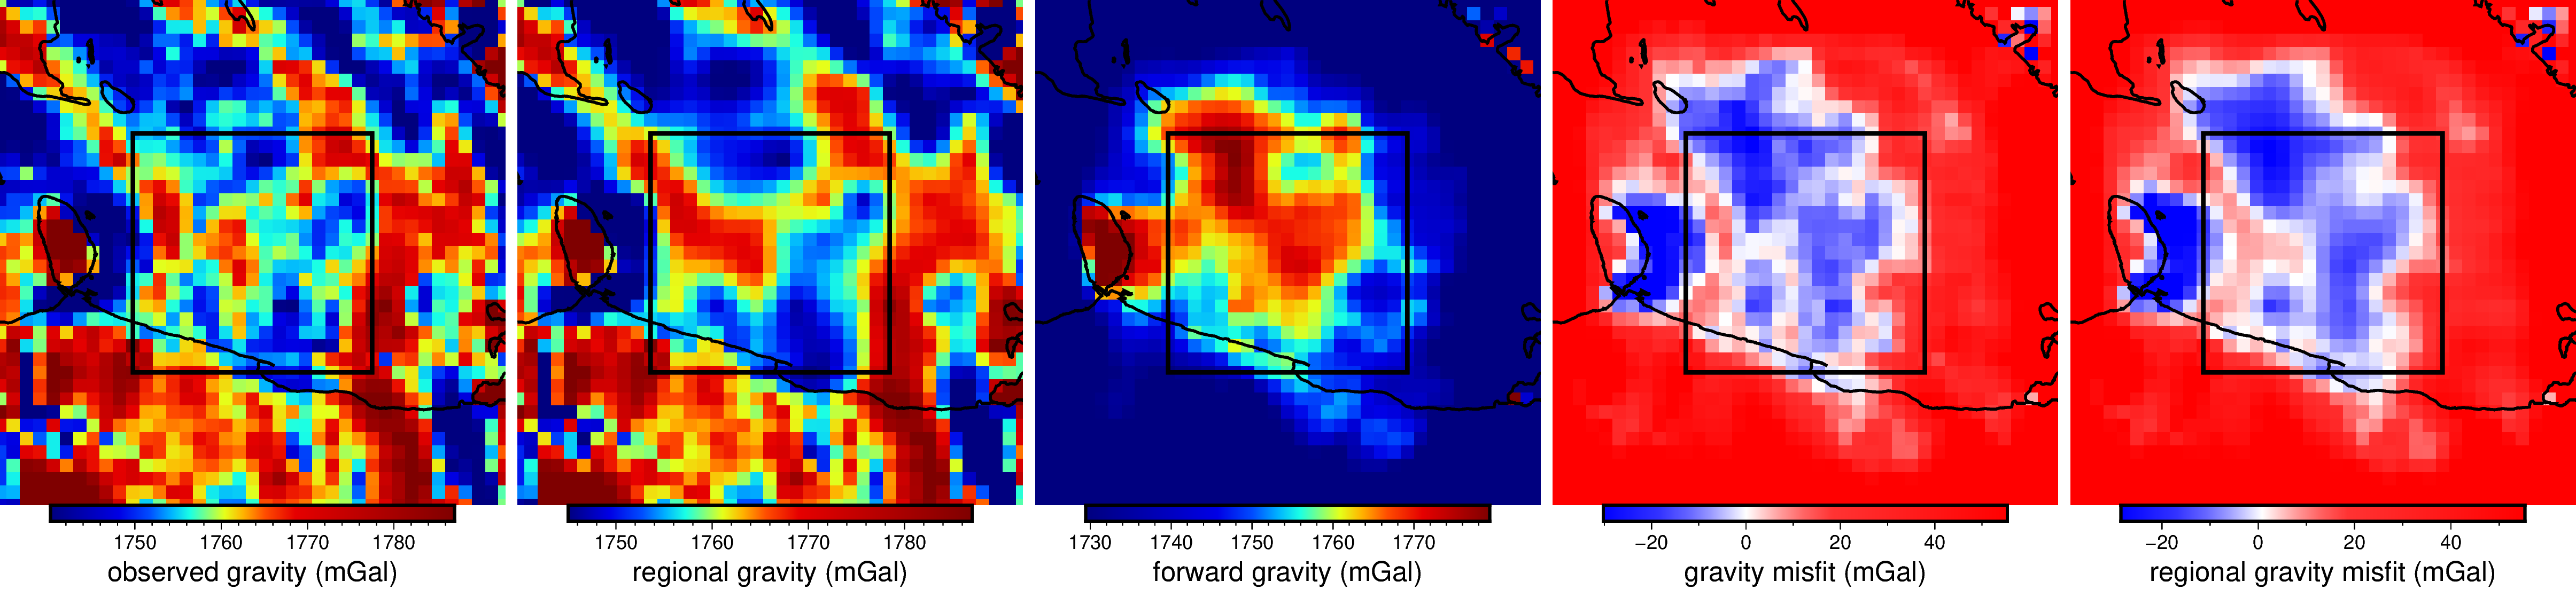

In [8]:
###
grid = Gobs_shift_grid
###
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, 
            continuous=True, output = 'plotting/grav.cpt')
plot_grd(grid=grid, cmap='plotting/grav.cpt',
    cbar_label = "observed gravity (mGal)",)

###
grid = Gfor_constraints_grid
###
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, 
            continuous=True, output = 'plotting/grav.cpt')
plot_grd(grid=grid,cmap='plotting/grav.cpt', 
    cbar_label = "regional gravity (mGal)",subplots=True)
    
###
grid = Gfor_grid
###
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, 
            continuous=True, output = 'plotting/grav.cpt')
plot_grd(grid=grid,cmap='plotting/grav.cpt', 
    cbar_label = "forward gravity (mGal)",subplots=True)

###
grid = Gmisfit_grid
###
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=fig_reg, background=True, 
            continuous=True, output = 'plotting/grav.cpt')
plot_grd(grid=grid, cmap='plotting/grav.cpt',
    cbar_label = "gravity misfit (mGal)", subplots=True)

###
grid = Gmisfit_constraints_grid
###
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=fig_reg, background=True, 
            continuous=True, output = 'plotting/grav.cpt')
plot_grd(grid=grid, cmap='plotting/grav.cpt',
    cbar_label = "regional gravity misfit (mGal)", subplots=True)

fig.show()

# Density inversion
We want the density distribution for the basement layer to account for the regional field, so the remaining gravity anomaly, the residual, is used in the geometry-bathy inversion

To do this, will run below density inversion on the basement layer the the forward gravity total - regional gravity as the input gravity grid

In [ ]:
#########
active_layer = 'bathymetry'
#########

forward_grav_layers(layers=layers)
spacing = layers[active_layer]['spacing']
max_density_change=1000 #kg/m3

# df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total']
df_grav['inv_misfit']=df_grav.Gobs_constraints-df_grav[f'forward_grav_total']

df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

# get prisms' coordinates from active layer
prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()

print(f'active layer average density: {int(prisms.density.mean())}kg/m3')

MAT_DENS = (np.zeros([len(df_grav),len(prisms)]))

print(f"initial RMSE = {int(np.sqrt((df_grav_inner['inv_misfit'] **2).mean()))}mGal")
print('calculating sensitivity matrix to determine density correction')

prisms_n=[]
for x in range(len(layers[active_layer]['prisms'].easting.values)):
    for y in range(len(layers[active_layer]['prisms'].northing.values)):
        prisms_n.append(layers[active_layer]['prisms'].prism_layer.get_prism((x,y)))
for col, prism in enumerate(prisms_n):
    MAT_DENS[:, col] = hm.prism_gravity(
        coordinates = (df_grav.x, df_grav.y, df_grav.z),
        prisms = prism,
        density = 1,
        field = 'g_z',
    )

# Calculate shift to prism's densities to minimize misfit
# gives the amount that each column's rho needs to change by to have the smallest misfit      
Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]

# if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Density_correction
# for i in range(0,len(prisms)):
#     if Density_correction[i] > max_density_change/1000:
#         Density_correction[i]=max_density_change/1000
#     elif Density_correction[i] < -max_density_change/1000:
#         Density_correction[i]=-max_density_change/1000

# resetting the rho values with the above correction
# harmonica uses 2600, grav_box/grav_col_der uses 2.6, so density correction needs to be *1000 for harmonica
prisms['updated_density']=Density_correction*100
dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.updated_density, 
                region=inv_reg, spacing=grav_spacing, projection=inv_proj)

# apply the rho correction to the prism layer
layers[active_layer]['prisms']['density'].values=dens_update.values
print(f"average density: {int(layers[active_layer]['prisms'].to_dataframe().reset_index().dropna().density.mean())}kg/m3")
# recalculate forward gravity of active layer               
print('calculating updated forward gravity')
df_grav[f'forward_grav_{active_layer}'] = layers[active_layer]['prisms'].prism_layer.gravity(
        coordinates=(df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z')

# ###
# grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
# ###
# pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=fig_reg, background=True, 
#             continuous=True, output = 'plotting/misfit.cpt')
# plot_grd(grid=grid, cmap='plotting/misfit.cpt',
#     cbar_label = "initial misfit (mGal)",)

# # Recalculate of gravity misfit, i.e., the difference between calculated and observed gravity
# df_grav['forward_grav_total'] = df_grav.forward_grav_total - df_grav[f'{active_layer}_forward_grav'] + df_grav[f'forward_grav_{active_layer}']
# df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav['forward_grav_total']
# df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()
# print(f"RMSE after inversion = {int(np.sqrt((df_grav_inner['inv_misfit'] **2).mean()))}mGal")
# dens_correction = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=Density_correction*100, 
#                 region=inv_reg, spacing=grav_spacing, projection=inv_proj)

# ###
# grid = dens_correction
# ###
# plot_grd(grid=grid, cmap='polar+h0',
#     cbar_label = "density correction (kg/m3)", subplots=True)

# ###
# grid = dens_update
# ###
# plot_grd(grid=grid, cmap='viridis',
#     cbar_label = "updated density (kg/m3)", subplots=True)

# ###
# grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
# ###
# plot_grd(grid=grid, cmap='plotting/misfit.cpt',
#     cbar_label = "final misfit (mGal)", subplots=True)

# fig.show()

# Prism geometry inversion

mean elevation of basement top: -2644.336181640625 and bottom: -15821.453125
mean elevation of bathymetry top: -567.5796508789062 and bottom: -2644.468505859375
mean elevation of water top: -210.47372436523438 and bottom: -570.7496948242188
mean elevation of ice top: 58.0676155090332 and bottom: -213.59361267089844
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer
finished basement layer
##################################
 iteration 1
active layer average depth: -567m
initial RMSE = 14mGal
RMSE after iteration 1 = 7.263648305857184


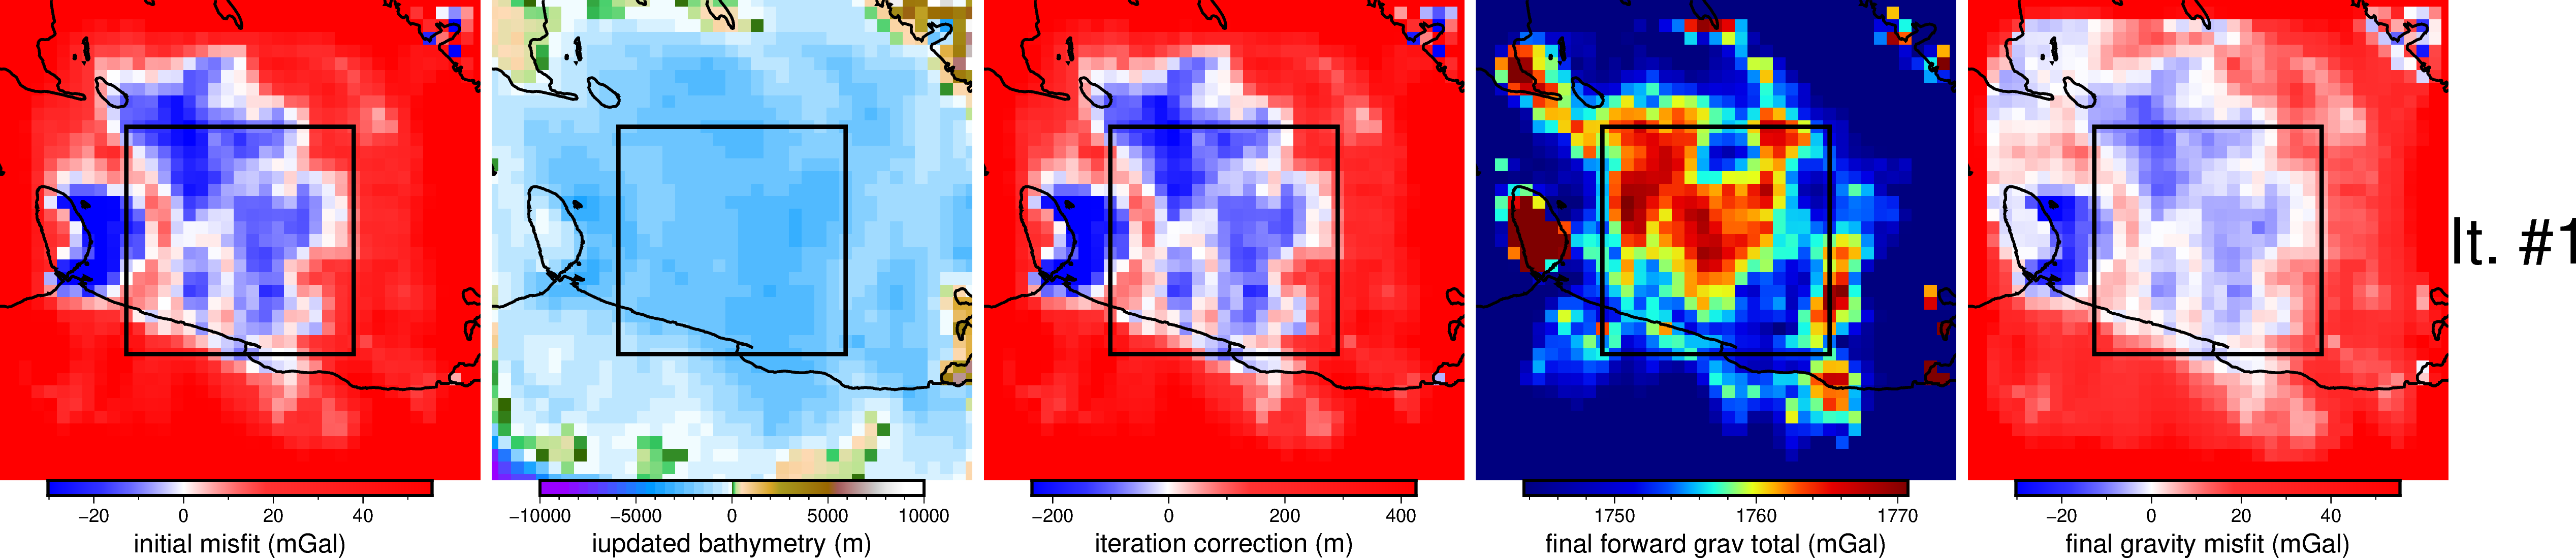

##################################
 iteration 2
active layer average depth: -327m
initial RMSE = 7mGal
RMSE after iteration 2 = 3.7688928911009194


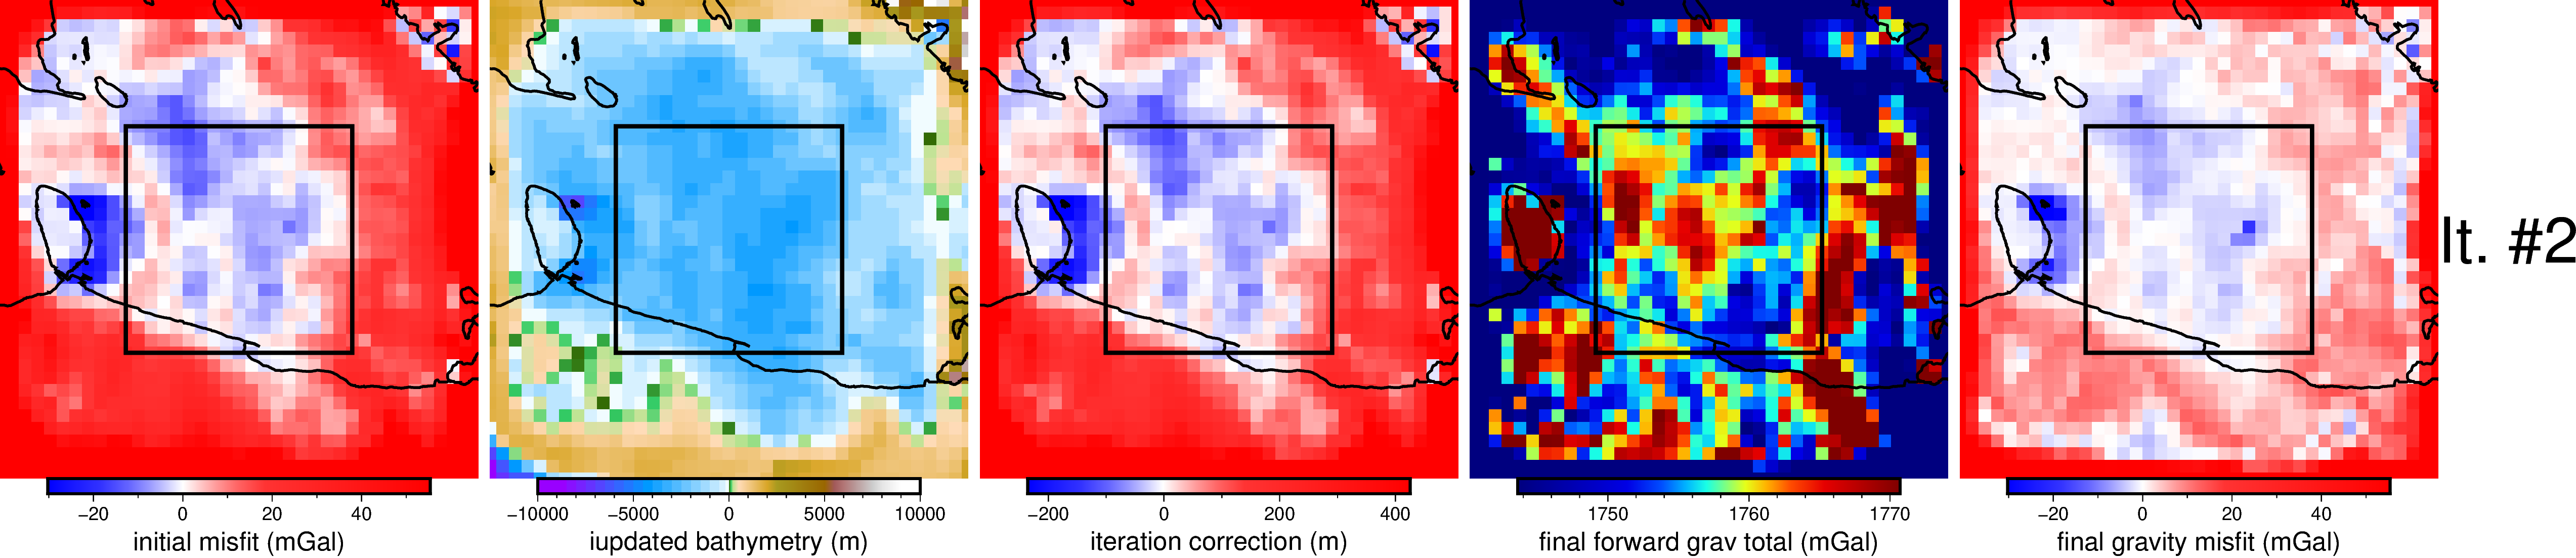

##################################
 iteration 3
active layer average depth: -167m
initial RMSE = 3mGal
RMSE after iteration 3 = 2.464098943670646
Inversion terminated after 3 iterations with least-squares norm=6 because maximum number of iterations (3) reached


In [21]:
#########
active_layer = 'bathymetry'
#########
forward_grav_layers(layers=layers)

prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
# prisms_inner = prisms[(prisms.easting.between(e_fig, w_fig)) & (prisms.northing.between(n_fig, s_fig))].copy()

df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total']
df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

spacing = layers[active_layer]['spacing'] 
misfit_sq_tolerance=.001
delta_misfit_squared_tolerance=0.02
Max_Iterations=3
max_layer_change_per_iter=500 #meters

misfit_squared_updated=np.Inf  # positive infinity
delta_misfit_squared=np.Inf  # positive infinity

ITER=0
 # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
    ITER=ITER+1 
    print(f"##################################\n iteration {ITER}")

    # get prisms' coordinates from active layer and layer above
    prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
    ind = layers_list.index(active_layer)
    prisms_above = layers[layers_list[ind-1]]['prisms'].to_dataframe().reset_index().dropna()

    print(f'active layer average depth: {int(prisms.top.mean())}m')

    MATDATPAR = (np.zeros([len(df_grav),len(prisms)]))

    # calculate MATDATPAR with grav_column_der
    print(f"initial RMSE = {int(np.sqrt((df_grav_inner['inv_misfit'] **2).mean()))}mGal")
    # print('calculating Jacobian matrix to determine surface correction')
    for i,j in enumerate((df_grav.Gobs)):
        # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
        #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        MATDATPAR[i,:]=grav_column_der(
                                    df_grav.y.iloc[i], # coords of gravity observation points
                                    df_grav.x.iloc[i],
                                    df_grav.z.iloc[i],  
                                    prisms.northing, prisms.easting,     
                                    prisms.top, 
                                    prisms.bottom,
                                    spacing,     
                                    prisms.density/1000)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
    # Calculate shift to prism's tops to minimize misfit
    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,df_grav['inv_misfit'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,len(prisms)):
        if Surface_correction[i] > max_layer_change_per_iter:
            Surface_correction[i]=max_layer_change_per_iter
        elif Surface_correction[i] < -max_layer_change_per_iter:
            Surface_correction[i]=-max_layer_change_per_iter
    
    # multiply surface correction by constraints grid, with RIGGS/onshore points =0, tapering to 1 at 5km.
    # this will change surface correction to be 0 at control points
    
    # resetting the Z values with the above corrections 
    prisms.top = prisms.top + Surface_correction
    prisms_above.bottom = prisms_above.bottom + Surface_correction

    # apply the z correction to the active prism layer and the above layer with Harmonica 
    layers[active_layer]['prisms'].prism_layer.update_top_bottom(
                    pygmt.xyz2grd(prisms[['easting','northing','top']], region=inv_reg, spacing=spacing), 
                    layers[active_layer]['prisms'].bottom)
    layers[layers_list[ind-1]]['prisms'].prism_layer.update_top_bottom(
                    layers[layers_list[ind-1]]['prisms'].top, 
                    pygmt.xyz2grd(prisms_above[['easting','northing','bottom']], region=inv_reg, spacing=spacing))

    # recalculate forward gravity of active layer and above layer               
    # print('calculating updated forward gravity')
    df_grav[f'forward_grav_{active_layer}_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
    df_grav[f'forward_grav_{layers_list[ind-1]}_{ITER}'] = layers[layers_list[ind-1]]['prisms'].prism_layer.gravity(
        coordinates=(df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z')


    ###
    grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
    ###
    if ITER == 1:
        pygmt.grd2cpt(cmap='polar+h0', grid=grid, continuous=True, region=fig_reg, background=True, output="plotting/misfit.cpt")
    else:
        pass
    plot_grd(grid=grid, cmap='plotting/misfit.cpt',
        cbar_label = "initial misfit (mGal)",)

    # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
    # replace previous forward grav of layer with newly calculated forward grav
    df_grav[f'forward_grav_total_{ITER}'] = \
                    df_grav.forward_grav_total - \
                    df_grav[f'{active_layer}_forward_grav'] - \
                    df_grav[f'{layers_list[ind-1]}_forward_grav'] + \
                    df_grav[f'forward_grav_{active_layer}_{ITER}']  + \
                    df_grav[f'forward_grav_{layers_list[ind-1]}_{ITER}']
                    
    df_grav[f'inv_misfit'] = df_grav.Gobs_shift-df_grav[f'forward_grav_total_{ITER}']
    df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()
    print(f"RMSE after iteration {ITER} = {np.sqrt((df_grav_inner['inv_misfit'] **2).mean())}")
    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
    misfit_sq=np.mean(df_grav_inner[f'inv_misfit']**2)
    delta_misfit_squared=misfit_squared_updated/misfit_sq
    misfit_squared_updated=misfit_sq # updated 
    # print(f"delta_misfit_squared={delta_misfit_squared}")
    # print(f"Iteration {ITER} terminated with least-squares norm={int(misfit_sq)}, executing iteration {ITER+1}")
    
    ###
    layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=inv_reg, spacing=spacing)
    grid=layers[active_layer]['inv_grid']
    ###
    plot_grd(grid=grid, cmap='globe',
        cbar_label = "iupdated bathymetry (m)", subplots=True)

    ###
    grid = pygmt.xyz2grd(x=prisms.easting,y=prisms.northing, z=Surface_correction, region=inv_reg, spacing=spacing)
    ###
    if ITER == 1:
        pygmt.grd2cpt(cmap='polar+h0', grid=grid, continuous=True, region=fig_reg, background=True, output="plotting/corr.cpt")
    else:
        pass
    plot_grd(grid=grid, cmap='plotting/corr.cpt',
        cbar_label = "iteration correction (m)",subplots=True)

    ###
    grid = pygmt.xyz2grd(df_grav[['x','y',f'forward_grav_total_{ITER}']], region=inv_reg, spacing=grav_spacing)
    ###
    if ITER == 1:
        pygmt.grd2cpt(cmap='jet', grid=grid, continuous=True, region=fig_reg, background=True, output="plotting/grav.cpt")
    else:
        pass
    plot_grd(grid=grid, cmap='plotting/grav.cpt',
        cbar_label = "final forward grav total (mGal)",subplots=True)

    ###
    grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
    ###
    plot_grd(grid=grid, cmap='plotting/misfit.cpt',
        cbar_label = "final gravity misfit (mGal)",subplots=True)
    
    # plot iteration label
    fig.shift_origin(xshift=((plot_width)/10))
    fig.text(projection = projection, 
        region = inv_reg,
        position='ML',
        justify='ML',
        text = f"It. #{ITER}",
        font = '30p,Helvetica,black',
        clearance = '+tO')
    fig.shift_origin(xshift=-((plot_width)/10))
    
    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
        break
    if misfit_sq < misfit_sq_tolerance:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
        break

    fig.show()

# end of inversion iteration WHILE loop
if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
    print("terminated - no significant variation in least-squares norm ")

In [ ]:
# Fabio's test grids
# inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I20e3  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')
# grav = xr.load_dataset('inversion_layers/gravity_inv.nc')

# surface = xr.load_dataset('inversion_layers/BedMachine_surface_filled_inv.nc')
# icebase = xr.load_dataset('inversion_layers/BedMachine_icebase_filled_inv.nc')
# bed = xr.load_dataset('inversion_layers/BedMachine_bed_inv.nc')
# basement = xr.load_dataset('inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

# df_grav=grav.to_dataframe().reset_index()
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# # df_grav['z']=750
# df_grav['z']=surface.to_dataframe().reset_index().z+750
# df_grav

In [ ]:
# TREND_TYPE = 'Constant value'
# # TREND_TYPE = 'Linear'
# # TREND_TYPE = 'Full regional correction'

# # set type of regional correction
# if TREND_TYPE == "Constant value":
#     df_grav['regional_grav'] = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean()
#     # df_grav['regional_grav'] = df_grav.forward_grav_misfit.mean()
#     print(df_grav['regional_grav'].mean())

# elif TREND_TYPE == 'Linear':
#     # ATEMP=np.column_stack((np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])), 
#     #                         df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]))
#     #                         df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))], 
#     # C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])
#     # df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])) + C[1]*df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))] + C[2]*df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]
#     ATEMP=np.column_stack((np.ones(len(df_grav.Gobs)), 
#                             df_grav.x, 
#                             df_grav.y))
#     C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit)
#     df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs)) + C[1]*df_grav.y + C[2]*df_grav.x
#     # print(C[0])
    
# elif TREND_TYPE == 'Full regional correction':
#      df_grav['regional_grav'] = df_grav.forward_grav_misfit

# # calculate residual gravity to be inverted
# df_grav['residual_grav'] = df_grav.Gobs - df_grav.regional_grav 

# residual_grav_grid=pygmt.surface(data = df_grav[['x','y','residual_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# regional_grav_grid=pygmt.surface(data = df_grav[['x','y','regional_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# # plot the grids
# fig = pygmt.Figure()

# # plot observed gravity
# data=grid_grav.z
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#         data,
#         cmap=True,
#         projection=fig_proj, 
#         region=fig_reg,
#         nan_transparent=True,
#         frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot regional gravity
# fig.shift_origin(xshift=(fig_width)/10)
# data=regional_grav_grid
# try:
#     pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
#     # pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
# except:
#     pass
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"regional gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot residual gravity
# fig.shift_origin(xshift=(fig_width+1)/10)
# data=residual_grav_grid
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"residual gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# fig.show()
# df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].describe()

In [ ]:
# #########
# active_layer = 'bathymetry'
# #########

# df_grav['grav_inversion']=df_grav.Gobs_shift

# df = layers[active_layer]['prisms'].to_dataframe().reset_index()

# MATDATPAR = (np.zeros([len(df_grav),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns


# spacing = layers[active_layer]['spacing'] 

# for i,j in enumerate(tqdm(df_grav.Gobs)):
#     # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
#     #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
#     # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
#     MATDATPAR[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
#                                             df_grav.x.iloc[i],
#                                             df_grav.z.iloc[i],  
#                                             df.northing, df.easting,     
#                                             df.top, 
#                                             df.bottom,
#                                             spacing,     
#                                             df.density/1000)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
# MATDATPAR

In [ ]:
# same as above but with matplotlib
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(ncols=1+len(layers), figsize=(5*(1+len(layers)),4))

# # GRAVITY PLOT
# grid_grav.z.plot(ax=axes[0], cmap='coolwarm', robust=True)
# axes[0].set_title('Observed gravity')

# # LAYERS PLOTS
# for i, (k, v) in enumerate(layers.items()):
#     layers[k]['grid'].z.plot(ax=axes[i+1], cmap='terrain', vmin=-10000, vmax=10000, center=0, robust=True)
#     axes[i+1].set_title(f'{k} elevation')

# # ALL PLOTS
# for i in axes:
#     i.set_aspect('equal')
#     i.add_patch(mpl.patches.Rectangle(
#     (e_fig, n_fig), w_fig-e_fig, s_fig-n_fig, lw=2, fill=False) ) 

# plt.tight_layout()


In [ ]:
# from pygmt import session_management
# session_management.end()
# session_management.begin()
